# Data Wrangling

## Problem statement
Context\
Raman spectroscopy could be an alteranative to PCR technique (current diagnostic method for SARS-CoV-2). Though PCR is sensitive, specific, and accrurate method, it might be time consuming in pendemic situations. Raman spectroscopy on the other hand is cheap and quick method. 

In this project we develop a classification type machine learning model tha enables us to correctly diagnose SARS-CoV-2. 

Dataset\

- `covid_and_healthy_spectra.csv`
- `suspected_spectra.csv`

Acknowledgements:\
Yin, Gang; Li, Lintao; Lu, Shun; Yin, Yu; Su, Yuanzhang; Zeng, Yilan; et al. (2020): Data and code on serum Raman spectroscopy as an efficient primary screening of coronavirus disease in 2019 (COVID-19). figshare. Dataset. https://doi.org/10.6084/m9.figshare.12159924.v1


## Imports

Let us import all libraries here. One place to consult for notebook dependencies  

In [2]:
# Import libraries 
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error,classification_report
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import datetime
from seaborn import heatmap
from library.sb_utils import save_file

## Load the covid spectral data

In [3]:
# set a path variable to the directory containing raman covid data:. ../raw_data/Raman_Covid
path = '../raw_data/Raman_Covid'
# Concatenate directory path to the file name: covid_path
covid_path = path + '/covid_and_healthy_spectra.csv'
# Load data file to a dataframe: covid_data
covid_data = pd.read_csv(covid_path)
# Preview content of file
covid_data.head()
# Load suspect data
suspect_data = pd.read_csv(path + '/suspected_spectra.csv');
suspect_data.shape
covid_data.head()

,400,402,405,407,410,412,415,417,420,422,...,2101,2103,2104,2105,2107,2108,2109,2111,2112,diagnostic
0,0.0,-0.015237,-0.030607,-0.038309,-0.039078,-0.035809,-0.031176,-0.030395,-0.033311,-0.031603,...,-0.000553,0.000118,0.000566,0.001245,0.000846,0.001106,0.001005,0.000117,0.0,Healthy
1,0.0,-0.012098,-0.028164,-0.035189,-0.036138,-0.031050,-0.026015,-0.027539,-0.028084,-0.027075,...,-0.000998,0.000278,-0.000123,0.000384,0.001010,0.000583,-0.000397,-0.000160,0.0,Healthy
2,0.0,-0.013000,-0.029058,-0.035021,-0.034994,-0.033025,-0.028413,-0.028470,-0.029737,-0.029198,...,-0.001554,0.000050,0.000866,0.000877,0.000871,0.001093,0.001058,0.000614,0.0,Healthy
3,0.0,-0.015728,-0.034346,-0.045140,-0.047671,-0.044334,-0.040807,-0.040474,-0.041417,-0.040699,...,-0.001541,-0.000198,0.000202,0.001023,0.000625,0.000420,0.000543,-0.000071,0.0,Healthy
4,0.0,-0.020355,-0.045839,-0.060556,-0.065805,-0.064988,-0.062097,-0.061955,-0.064759,-0.066886,...,-0.000088,0.000891,0.000942,0.001294,0.001878,0.001739,0.001946,0.001301,0.0,Healthy


## Explore the data

In [4]:
#Quickly audit data: covid_data.info()
covid_data.info()
covid_data.dtypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Columns: 901 entries, 400 to diagnostic
dtypes: float64(900), object(1)
memory usage: 2.1+ MB


400           float64
402           float64
405           float64
407           float64
410           float64
               ...   
2108          float64
2109          float64
2111          float64
2112          float64
diagnostic     object
Length: 901, dtype: object

###  Count the number of missing data

In [5]:
#Count (using `.sum()`) the number of missing values (`.isnull()`) in each column of 
#covid_data as well as the percentages (using `.mean()` instead of `.sum()`).
#rder them (increasing or decreasing) using sort_values
#Call `pd.concat` to present these in a single table (DataFrame) with the helpful column names 'count' and '%'
missing = pd.concat([covid_data.isnull().sum(), 100 * covid_data.isnull().mean()], axis=1)
missing.columns=['count', '%']
grouped_sum = missing.groupby(by=['count']).count()
grouped_sum
#missing.sort_values(by='count',ascending=True)

,%
count,
0,901


### Categorical features

Let us find and see all our categorial features.

In [6]:
#Use covid_data's `select_dtypes` method to select columns of dtype 'object'
covid_data.select_dtypes('object')

,diagnostic
0,Healthy
1,Healthy
2,Healthy
3,Healthy
4,Healthy
...,...
304,SARS-CoV-2
305,SARS-CoV-2
306,SARS-CoV-2
307,SARS-CoV-2


The only categorial feature in our data is column `diagnosis`

#### Unique categorical values
Let us see the unique categorial values of the feature `diagnostic`

In [7]:
#Use pandas' Series method `value_counts` to find any duplicated resort names
covid_data['diagnostic'].value_counts().head()

SARS-CoV-2    159
Healthy       150
Name: diagnostic, dtype: int64

The `diagnostic` feature has two unique values, namely: `SARS-Cov2` and `Healthy`. Our data consists of 159 Covid cases and 150 Healthy individuals.

#### Distribution of `diagnostic` categorical feature

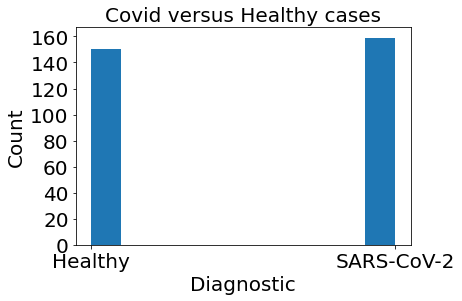

In [57]:
plt.hist(covid_data['diagnostic'])
plt.xlabel('Diagnostic',fontsize=20)
plt.ylabel('Count',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('Covid versus Healthy cases',fontsize=20)
plt.show()

### Numerical features

#### Distributions of numeric features

 We have 900 numerical features and generating all distirubtions at once may not efficient. Let us investigate the distribution of some selected numerical features.

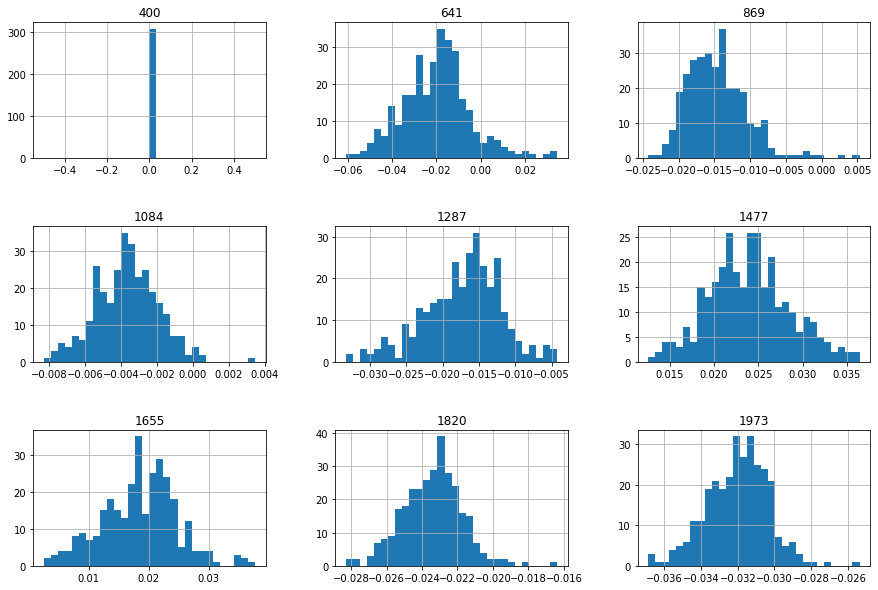

In [9]:
covid_data.iloc[:,0:901:100].hist(figsize=(15,10),bins=30)
plt.subplots_adjust(hspace=0.5);
plt.show()

What features do we have possible cause for concern about and why?

* several features like `400` because values are clustered down the low end,

It seems some features might have 0 values only. Let's find out which features display this behaviour.

#### Features with zero values

Get how many features we have with all zero values. 

In [10]:
# Get columns with all zero values
zero_covid_data = covid_data.loc[:, ~(covid_data != 0).any(axis=0)]
zero_covid_data.shape

(309, 9)

We have 9 features with all zero values. 

#### Distribution of zero numeric features

0.0    309
Name: 904, dtype: int64

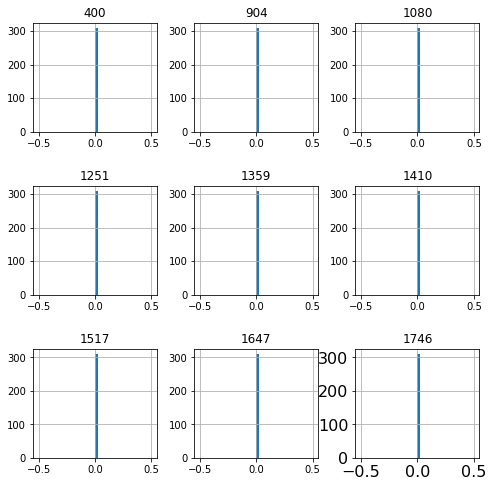

In [59]:
zero_covid_data.hist(figsize=(8,8),bins=40)
plt.subplots_adjust(hspace=0.5);
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#plt.show()
zero_covid_data['904'].value_counts()

#### Drop zero features
We need to drop columns with all values zero.

In [12]:
# drop columns with all values zero: zeroFree_Covid_data
zeroFree_covid_data = covid_data.loc[:, (covid_data != 0).any(axis=0)]
zeroFree_covid_data.head()
zeroFree_covid_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Columns: 892 entries, 402 to diagnostic
dtypes: float64(891), object(1)
memory usage: 2.1+ MB


## End Data Wrangling
At this point the data wrangling is completed and a cleaned data should be saved.
### Save clean data

In [13]:
# save the data to a new csv file
datapath = '../data'
save_file(zeroFree_covid_data, 'covid_data_cleaned.csv', datapath)

A file already exists with this name.

Do you want to overwrite? (Y/N)y
Writing file.  "../data\covid_data_cleaned.csv"


# Exploratory data analysis

## Visualizing high dimensional data

### Scale the data
Scale the numerical data

In [14]:
#Create a new dataframe, `covid_scale` from `covid_data` whilst setting the index to 'diagnostic'
covid_data_scale = covid_data.set_index('diagnostic')
covid_data_index = covid_data_scale.index

#Save the column names (using the `columns` attribute) of `covid_data_scale` into the variable 'covid_data_columns'
covid_data_columns = covid_data_scale.columns
covid_data_scale.head()

,400,402,405,407,410,412,415,417,420,422,...,2100,2101,2103,2104,2105,2107,2108,2109,2111,2112
diagnostic,,,,,,,,,,,,,,,,,,,,,
Healthy,0.0,-0.015237,-0.030607,-0.038309,-0.039078,-0.035809,-0.031176,-0.030395,-0.033311,-0.031603,...,-0.001685,-0.000553,0.000118,0.000566,0.001245,0.000846,0.001106,0.001005,0.000117,0.0
Healthy,0.0,-0.012098,-0.028164,-0.035189,-0.036138,-0.031050,-0.026015,-0.027539,-0.028084,-0.027075,...,-0.002085,-0.000998,0.000278,-0.000123,0.000384,0.001010,0.000583,-0.000397,-0.000160,0.0
Healthy,0.0,-0.013000,-0.029058,-0.035021,-0.034994,-0.033025,-0.028413,-0.028470,-0.029737,-0.029198,...,-0.002707,-0.001554,0.000050,0.000866,0.000877,0.000871,0.001093,0.001058,0.000614,0.0
Healthy,0.0,-0.015728,-0.034346,-0.045140,-0.047671,-0.044334,-0.040807,-0.040474,-0.041417,-0.040699,...,-0.003241,-0.001541,-0.000198,0.000202,0.001023,0.000625,0.000420,0.000543,-0.000071,0.0
Healthy,0.0,-0.020355,-0.045839,-0.060556,-0.065805,-0.064988,-0.062097,-0.061955,-0.064759,-0.066886,...,-0.002151,-0.000088,0.000891,0.000942,0.001294,0.001878,0.001739,0.001946,0.001301,0.0


In [15]:
# Now use `scale()` to scale the above dataframe: 
covid_data_scale = scale(covid_data_scale)
type(covid_data_scale) # is numpy.ndarray

# Convert the numpy array to a dataframe
covid_data_scaled_df = pd.DataFrame(covid_data_scale, columns=covid_data_columns)
covid_data_scaled_df.head()

,400,402,405,407,410,412,415,417,420,422,...,2100,2101,2103,2104,2105,2107,2108,2109,2111,2112
0,0.0,0.029396,-0.169466,-0.307398,-0.298645,-0.220519,-0.089324,-0.057396,-0.199405,-0.153902,...,0.303745,0.267238,0.045011,-0.275664,0.052013,-0.617603,-0.261925,0.063182,-0.714883,-0.048027
1,0.0,0.675565,0.094517,-0.058681,-0.088368,0.110636,0.268129,0.137068,0.134956,0.123774,...,-0.152282,-0.255200,0.224225,-1.041502,-0.875838,-0.441492,-0.882364,-1.648331,-1.110855,-0.048027
2,0.0,0.489933,-0.002139,-0.045266,-0.006537,-0.026791,0.102018,0.073686,0.029234,-0.006420,...,-0.859510,-0.907826,-0.031248,0.057741,-0.344697,-0.591279,-0.277629,0.127861,-0.004499,-0.048027
3,0.0,-0.071710,-0.573591,-0.852038,-0.913352,-0.813618,-0.756254,-0.743490,-0.717955,-0.711807,...,-1.468136,-0.893057,-0.309769,-0.680144,-0.187659,-0.856039,-1.075968,-0.501265,-0.983932,-0.048027
4,0.0,-1.024163,-1.815651,-2.081085,-2.210501,-2.250611,-2.230541,-2.205891,-2.211147,-2.317930,...,-0.227672,0.812778,0.912016,0.141430,0.104768,0.492144,0.489360,1.212373,0.977471,-0.048027


### PCA transformation

In [16]:
covid_pca = PCA().fit(covid_data_scale)

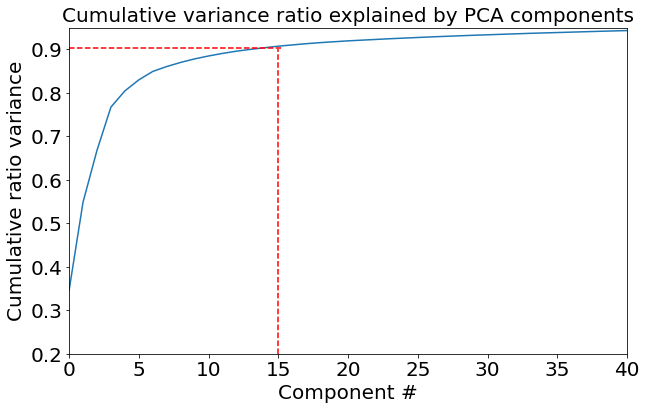

In [55]:
#plot cumultatice variance of covid data explained versus principal components
# xlabel = 'Component #' and ylabel = 'Cumulative ratio variance'
#title = 'Cumulative variance ratio explained by PCA 

plt.subplots(figsize=(10, 6))
plt.plot(covid_pca.explained_variance_ratio_.cumsum())
plt.xlabel('Component #',fontsize=20)
plt.ylabel('Cumulative ratio variance',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim(0.0,40)
plt.ylim(0.2,0.95)
plt.axvline(x=15,ymax= covid_pca.explained_variance_ratio_.cumsum()[30],c='r',ls='--')
plt.axhline(y= covid_pca.explained_variance_ratio_.cumsum()[14],xmax=0.38,c='r',ls='--')

plt.title('Cumulative variance ratio explained by PCA components',fontsize=20);

In [17]:
#Call `covid_pca`'s `transform()` method, passing in `covid_data_scale` as its argument
covid_pca_x = covid_pca.transform(covid_data_scale)
covid_pca_x.shape
covid_pca_x

array([[-4.47152537e+00,  4.32022561e+00, -7.82439753e+00, ...,
         4.82606869e-02, -5.78636810e-02, -1.42941214e-15],
       [-1.18408179e+00, -1.91441652e+00, -4.30435325e+00, ...,
        -1.28964207e-01,  7.77789696e-02, -2.31759056e-15],
       [-9.90559314e-01, -2.18369859e+00, -6.24443553e+00, ...,
         1.30861429e-01, -1.39219592e-01, -1.33226763e-15],
       ...,
       [-7.54779908e+00, -7.72164026e+00, -8.36052344e+00, ...,
         5.82241140e-02, -1.82147472e-02,  1.06858966e-15],
       [-1.27333845e+00, -3.34755165e+01, -6.95441083e-01, ...,
        -2.81639292e-02, -3.74981250e-02, -2.27595720e-15],
       [-1.75529832e+01, -5.93393249e+00,  3.24359823e+00, ...,
         1.32136283e-03,  2.88688460e-02,  5.55111512e-16]])

In [61]:
from sklearn.model_selection import train_test_split
X = covid_pca_x[:,0:14]
y = covid_data_index
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=0)

In [66]:
# define a function for generating modeles
def models(X_train,Y_train):
        #logistic regression
        from sklearn.linear_model import LogisticRegression
        #log = LogisticRegression(random_state=0)
        log = LogisticRegression()
        log.fit(X_train,y_train)
        heatmap(cm, annot=True, fmt="g", yticklabels=["Healthy", "COVID"] ,xticklabels=["Healthy", "COVID"])
        plt.title("Confusion matrix: test" +  "\n"  + "Model: " + model_label[0],fontsize=20)
        plt.xlabel("Predicted",fontsize=20)
        plt.ylabel("Target",fontsize=20)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.show()
        print('Misclassified samples: %d' % (y_train != log.predict(X_train)).sum())
        print(f"Logistic regression: PCA 15 components \n Classification report for train-dataset:\n{classification_report(log.predict(X_train), y_train)}")
        #Decision tree
        from sklearn.tree import DecisionTreeClassifier
        #tree = DecisionTreeClassifier(criterion='entropy',random_state=0)
        tree = DecisionTreeClassifier()
        tree.fit(X_train,y_train)
        #print('Misclassified samples: %d' % (y_train != tree.predict(X_train)).sum())
        #print(f"Decision tree: PCA 15 components \n Classification report for train-dataset:\n{classification_report(tree.predict(X_train), y_train)}")
        #Random Forest
        from sklearn.ensemble import RandomForestClassifier
        #forest = RandomForestClassifier(n_estimators=10,criterion='entropy',random_state=0)
        forest = RandomForestClassifier()
        forest.fit(X_train,y_train)
        print('Misclassified samples: %d' % (y_train != forest.predict(X_train)).sum())
        print(f"Random Forest: PCA 15 components \n Classification report for train-dataset:\n{classification_report(forest.predict(X_train), y_train)}")
        #print the models accuracy
        print('[0] Logistic Regression Accuracy: ', log.score(X_train,y_train))
        print('[0] Decision Tree Accuracy: ', tree.score(X_train,y_train))
        print('[0] Random Forest Accuracy: ', forest.score(X_train,y_train))
        return log,tree,forest

model = models(X_train,y_train)

Misclassified samples: 6
Logistic regression: PCA 15 components 
 Classification report for train-dataset:
              precision    recall  f1-score   support

     Healthy       0.98      0.96      0.97       112
  SARS-CoV-2       0.97      0.98      0.97       119

    accuracy                           0.97       231
   macro avg       0.97      0.97      0.97       231
weighted avg       0.97      0.97      0.97       231

Misclassified samples: 0
Random Forest: PCA 15 components 
 Classification report for train-dataset:
              precision    recall  f1-score   support

     Healthy       1.00      1.00      1.00       110
  SARS-CoV-2       1.00      1.00      1.00       121

    accuracy                           1.00       231
   macro avg       1.00      1.00      1.00       231
weighted avg       1.00      1.00      1.00       231

[0] Logistic Regression Accuracy:  0.974025974025974
[0] Decision Tree Accuracy:  1.0
[0] Random Forest Accuracy:  1.0


Model:  LogisticRegression
Testing accuracy:  0.9615384615384616




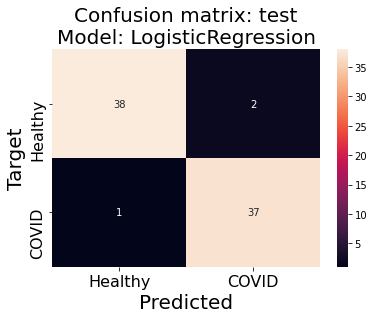

Model:  DecisionTreeClassifier
Testing accuracy:  0.8589743589743589




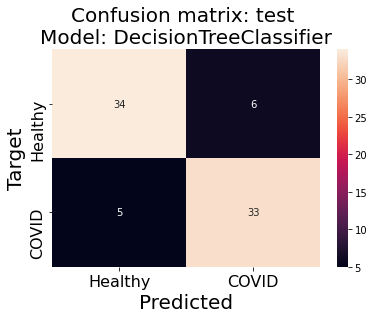

Model:  RandomForestClassifier
Testing accuracy:  0.9615384615384616




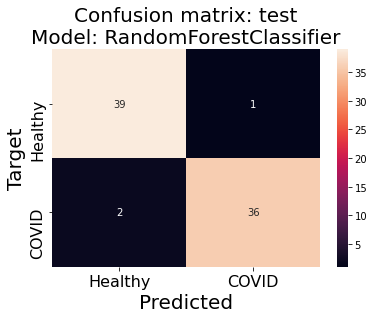

In [77]:
# Test on test data set

from sklearn.metrics import confusion_matrix
for i in range(len(model)):
    model_label = str(model[i]).split('(')
    cm = confusion_matrix(y_test,model[i].predict(X_test))
    print('Model: ',model_label[0])
    TP = cm[0][0]
    TN = cm[1][1]
    FN = cm[1][0]
    FP = cm[0][1]
    Accuracy = (TN + TP)/(TN+TP+FN+FP)
    print('Testing accuracy: ', Accuracy)
    print('\n')
    if i==0:
        heatmap(cm, annot=True, fmt="g", yticklabels=["Healthy", "COVID"] ,xticklabels=["Healthy", "COVID"])
        plt.title("Confusion matrix: test" +  "\n"  + "Model: " + model_label[0],fontsize=20)
        plt.xlabel("Predicted",fontsize=20)
        plt.ylabel("Target",fontsize=20)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.show()
    elif i == 1:
        heatmap(cm, annot=True, fmt="g", yticklabels=["Healthy", "COVID"] ,xticklabels=["Healthy", "COVID"])
        plt.title("Confusion matrix: test " +  "\n"  + "Model: " + model_label[0],fontsize=20)
        plt.xlabel("Predicted",fontsize=20)
        plt.ylabel("Target",fontsize=20)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.show()
    else:
        heatmap(cm, annot=True, fmt="g", yticklabels=["Healthy", "COVID"] ,xticklabels=["Healthy", "COVID"])
        plt.title("Confusion matrix: test" +  "\n"  + "Model: " + model_label[0],fontsize=20)
        plt.xlabel("Predicted",fontsize=20)
        plt.ylabel("Target",fontsize=20)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.show()

Plot the first two principal components and label and color each point with `H` for healthy and `S` for SARS-Cov .

<AxesSubplot:title={'center':'Covid summary PCA, 54.9% variance explained'}, xlabel='PC1', ylabel='PC2'>

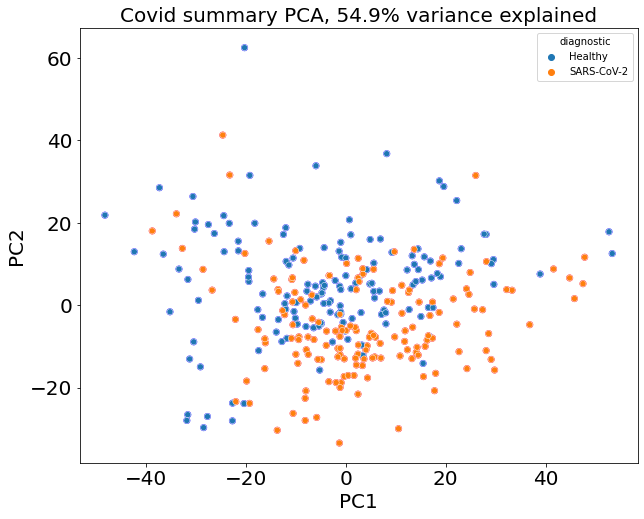

In [48]:
x = covid_pca_x[:, 0]
y = covid_pca_x[:, 1]
diagnostic = covid_data_index 
pc_var = 100 * covid_pca.explained_variance_ratio_.cumsum()[1]
plt.subplots(figsize=(10,8))
colors = {'Healthy':'blue', 'SARS-CoV-2':'red'}
plt.scatter(x=x, y=y,c=diagnostic.map(colors))
plt.xlabel('PC1',fontsize=20)
plt.ylabel('PC2',fontsize=20)
plt.title(f'Covid summary PCA, {pc_var:.1f}% variance explained',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(diagnostic.values)
#for s, x, y in zip(diagnostic, x, y):
#    plt.annotate(s[0], (x, y))
sns.scatterplot(x=x,y=y,hue=diagnostic)



## END Exploratory data analysis

# Preprocessing and training data

In [50]:
# Get number of columns and number of rows: ncols, nrows
covid_data = zeroFree_covid_data
ncols = covid_data.shape[1]
nrows = covid_data.shape[0]
nrows,ncols

(309, 892)

In [51]:
# Split data into dependent and independent variables
X = np.matrix(covid_data.iloc[:,0:ncols-1].values)
y = np.array(covid_data.iloc[:,ncols-1].values) 
labels = list(set(y))
labels

['SARS-CoV-2', 'Healthy']

(1, 891)


C:\Users\iabra\anaconda3\lib\site-packages\numpy\matrixlib\defmatrix.py:447: RuntimeWarning: Mean of empty slice.
  return N.ndarray.mean(self, axis, dtype, out, keepdims=True)._collapse(axis)
C:\Users\iabra\anaconda3\lib\site-packages\numpy\core\_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Text(0, 0.5, 'Intensity')

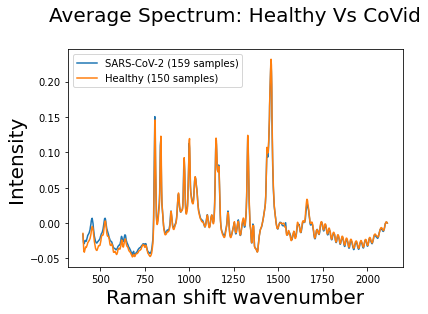

In [54]:
X_names = list(map(float, covid_data.columns.values[0:ncols-1])) # X_names = np.array(list(da
#print(X_names)
for c in labels: 
#    if c == 'Healthy':
        Xc = X[y == c]
        yc = y[y == c] 
        plt.plot(X_names, np.mean(Xc,axis=0).tolist()[0], label=  str(c) +  
                 ' (' + str(len(yc)) + ' samples)')
        plt.legend()
    
plt.title(u'Average Spectrum: Healthy Vs CoVid\n',fontsize=20) ;  
print(np.mean(X[y==1],axis=0).shape)
plt.xlabel('Raman shift wavenumber',fontsize=20)
plt.ylabel('Intensity',fontsize=20)

In [75]:
# Encode the categorical data
from sklearn.preprocessing import LabelEncoder
labelencoder_y = LabelEncoder()
covid_data.iloc[:,ncols-1] = labelencoder_y.fit_transform(covid_data.iloc[:,ncols-1].values)
y = np.array(covid_data.iloc[:,ncols-1].values)


## Train/test split

In [76]:
# split data into 75% training and 25% test
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=0)

## Initial simple models

In [77]:
# Scale the data 
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_tr_scaled = sc.fit_transform(X_train)
X_te_scaled = sc.fit_transform(X_test)

### Simple models function
Define a funnction that classifies our data using Logistic regression, decistion tree, and random forest models. And test it on the training data set.

#### Function on Training data 

In [78]:
# define a function for generating modeles
def models(X_train,Y_train):
        #logistic regression
        from sklearn.linear_model import LogisticRegression
        #log = LogisticRegression(random_state=0)
        log = LogisticRegression()
        log.fit(X_train,y_train)
        #Decision tree
        from sklearn.tree import DecisionTreeClassifier
        #tree = DecisionTreeClassifier(criterion='entropy',random_state=0)
        tree = DecisionTreeClassifier()
        tree.fit(X_train,y_train)
        #Random Forest
        from sklearn.ensemble import RandomForestClassifier
        #forest = RandomForestClassifier(n_estimators=10,criterion='entropy',random_state=0)
        forest = RandomForestClassifier()
        forest.fit(X_train,y_train)
        #print the models accuracy
        print('[0] Logistic Regression Accuracy: ', log.score(X_train,y_train))
        print('[0] Decision Tree Accuracy: ', tree.score(X_train,y_train))
        print('[0] Random Forest Accuracy: ', forest.score(X_train,y_train))
        return log,tree,forest

model = models(X_tr_scaled,y_train)

[0] Logistic Regression Accuracy:  1.0
[0] Decision Tree Accuracy:  1.0
[0] Random Forest Accuracy:  1.0


It looks like models are overfitting on the training data set and we need to test them with the test data set.

####  Function on Test data

Model:  LogisticRegression
Testing accuracy:  0.9615384615384616




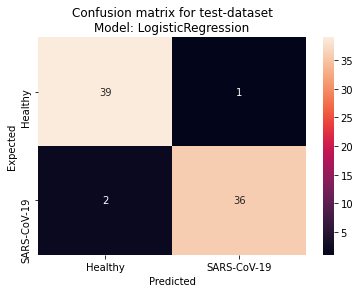

Model:  DecisionTreeClassifier
Testing accuracy:  0.8333333333333334




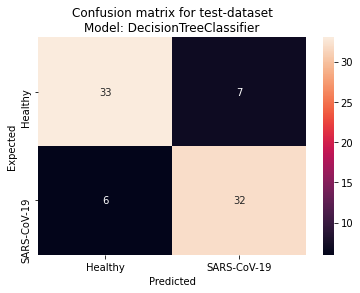

Model:  RandomForestClassifier
Testing accuracy:  0.9743589743589743




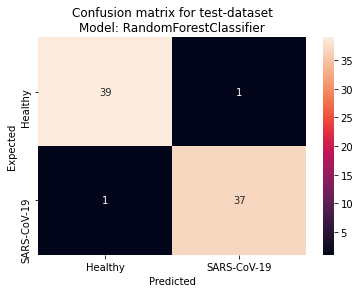

In [79]:
# Test on test data set

from sklearn.metrics import confusion_matrix
for i in range(len(model)):
    model_label = str(model[i]).split('(')
    cm = confusion_matrix(y_test,model[i].predict(X_te_scaled))
    print('Model: ',model_label[0])
    TP = cm[0][0]
    TN = cm[1][1]
    FN = cm[1][0]
    FP = cm[0][1]
    Accuracy = (TN + TP)/(TN+TP+FN+FP)
    print('Testing accuracy: ', Accuracy)
    print('\n')
    if i==0:
        heatmap(cm, annot=True, fmt="g", yticklabels=["Healthy", "SARS-CoV-19"] ,xticklabels=["Healthy", "SARS-CoV-19"])
        plt.title("Confusion matrix for test-dataset" +  "\n"  + "Model: " + model_label[0])
        plt.xlabel("Predicted")
        plt.ylabel("Expected")
        plt.show()
    elif i == 1:
        heatmap(cm, annot=True, fmt="g", yticklabels=["Healthy", "SARS-CoV-19"] ,xticklabels=["Healthy", "SARS-CoV-19"])
        plt.title("Confusion matrix for test-dataset" +  "\n"  + "Model: " + model_label[0])
        plt.xlabel("Predicted")
        plt.ylabel("Expected")
        plt.show()
    else:
        heatmap(cm, annot=True, fmt="g", yticklabels=["Healthy", "SARS-CoV-19"] ,xticklabels=["Healthy", "SARS-CoV-19"])
        plt.title("Confusion matrix for test-dataset" +  "\n"  + "Model: " + model_label[0])
        plt.xlabel("Predicted")
        plt.ylabel("Expected")
        plt.show()

On test data decision tree is performing poorly as compared to LogReg and Random Forest (RF). Random Forest performing the best and logistic regression next. 

## Pipelines
Now let us use sklearn's pipeline to generate our models. 

### Define pipeline Random Forest

In [80]:
#Define a pipeline comprising the steps:
#StandardScaler(),
#and then RandomForestRegressor() with a random state of 0
RF_pipe = make_pipeline(
                      StandardScaler(),
                      RandomForestClassifier(random_state=0)
                        )

#### Fit pipeline random forest

In [81]:
#Call the pipe's `fit()` method with `X_train` and `y_train` as arguments
RF_pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=None,
                                        oob_score=False, random_state=0,
                                        verbose=0, warm_start=False))],
         verbose=Fals

#### Make prediction on train and test set

In [82]:
y_tr_pred = RF_pipe.predict(X_train)
y_te_pred = RF_pipe.predict(X_test)

#### Assess performance random forest

In [83]:
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(1.0, 0.9486842105263158)

Compare this with the initial model results (1,0.9871794871794872). The simple model is performing better on the test set when using random forest with pipeline with standardscaler and random state =0. The model with the pipe seems to overfit aas well.

### Define pipline: Logistic regression

In [84]:
log_pipe = make_pipeline(
                        StandardScaler(),
                        LogisticRegression(random_state=0)
                        )

#### Fit pipeline logistic regression

In [85]:
#Call the pipe's `fit()` method with `X_train` and `y_train` as arguments
log_pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=0,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

#### Make predictions on train and test

In [86]:
y_tr_pred = log_pipe.predict(X_train)
y_te_pred = log_pipe.predict(X_test)

#### Assess performance on training/test data

In [87]:
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(1.0, 0.8973684210526316)

compare this result with (1.0,0.9615384615384616) (result of model function without pipeline). The perormance of the result with the model function is better, which means the use of standard scaler in the pipe reduced the accuracy.
Use of StandardScaler made both models worse.

#### Assess peformance using cross-validation
Models seem to overfit. Use cross validation and check

In [88]:
#Call `cross_validate` to estimate the pipeline's performance.
#Pass it the random forest pipe object, `X_train` and `y_train`,
#and get it to use 5-fold cross-validation
rf_default_cv_results = cross_validate(RF_pipe, X_train, y_train, cv=8)

In [89]:
rf_cv_scores = rf_default_cv_results['test_score']
rf_cv_scores

array([0.96551724, 0.89655172, 0.93103448, 0.89655172, 0.96551724,
       0.86206897, 0.86206897, 0.92857143])

In [90]:
np.mean(rf_cv_scores), np.std(rf_cv_scores)

(0.9134852216748768, 0.03842359598013761)

The model performance seemed to vary depending the number of cross validation folds (cv). We can use grid search to find the best value of cv.

## Hyperparameter search using GridSearchCV
### Refine random forest

In [91]:
# list avaialable parameters to optimize
RF_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'randomforestclassifier', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'randomforestclassifier__bootstrap', 'randomforestclassifier__ccp_alpha', 'randomforestclassifier__class_weight', 'randomforestclassifier__criterion', 'randomforestclassifier__max_depth', 'randomforestclassifier__max_features', 'randomforestclassifier__max_leaf_nodes', 'randomforestclassifier__max_samples', 'randomforestclassifier__min_impurity_decrease', 'randomforestclassifier__min_impurity_split', 'randomforestclassifier__min_samples_leaf', 'randomforestclassifier__min_samples_split', 'randomforestclassifier__min_weight_fraction_leaf', 'randomforestclassifier__n_estimators', 'randomforestclassifier__n_jobs', 'randomforestclassifier__oob_score', 'randomforestclassifier__random_state', 'randomforestclassifier__verbose', 'randomforestclassifier__warm_start'])

In [92]:
RF_pipe.get_params().keys() 

dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'randomforestclassifier', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'randomforestclassifier__bootstrap', 'randomforestclassifier__ccp_alpha', 'randomforestclassifier__class_weight', 'randomforestclassifier__criterion', 'randomforestclassifier__max_depth', 'randomforestclassifier__max_features', 'randomforestclassifier__max_leaf_nodes', 'randomforestclassifier__max_samples', 'randomforestclassifier__min_impurity_decrease', 'randomforestclassifier__min_impurity_split', 'randomforestclassifier__min_samples_leaf', 'randomforestclassifier__min_samples_split', 'randomforestclassifier__min_weight_fraction_leaf', 'randomforestclassifier__n_estimators', 'randomforestclassifier__n_jobs', 'randomforestclassifier__oob_score', 'randomforestclassifier__random_state', 'randomforestclassifier__verbose', 'randomforestclassifier__warm_start'])

**max_features**{“auto”, “sqrt”, “log2”}, int or float, default=”auto”

The number of features to consider when looking for the best split:

- If int, then consider max_features features at each split.

- If float, then max_features is a fraction and round(max_features * n_features) features are considered at each split.

- If “auto”, then max_features=sqrt(n_features).

- If “sqrt”, then max_features=sqrt(n_features) (same as “auto”).

- If “log2”, then max_features=log2(n_features).

- If None, then max_features=n_features.

In [93]:
X_traindf = pd.DataFrame(X_train)
k = [k+1 for k in range(0,len(X_traindf.columns),100)]
grid_params = {'randomforestclassifier__max_features': k}

Now we can investigate a range of k features.

In [94]:
rf_grid_cv = GridSearchCV(RF_pipe, param_grid=grid_params, cv=5, n_jobs=-1)

In [95]:
rf_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(bootstrap=True,
                                                               ccp_alpha=0.0,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                   

In [96]:
score_mean = rf_grid_cv.cv_results_['mean_test_score']
score_std = rf_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in rf_grid_cv.cv_results_['param_randomforestclassifier__max_features']]

In [97]:
rf_grid_cv.best_params_

{'randomforestclassifier__max_features': 101}

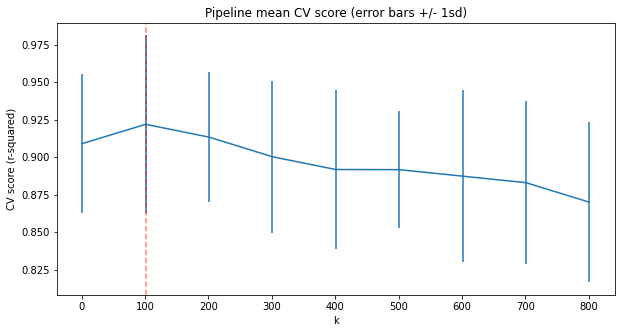

In [98]:
#Assign the value of k from the above dict of `best_params_` and assign it to `best_k`
best_k = rf_grid_cv.best_params_['randomforestclassifier__max_features']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

From the above plot we see that a maximum of 6 features should be considered at each split.

#### Assess performance using train/test

In [99]:
n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
grid_params = {
            'randomforestclassifier__n_estimators': n_est,
            'standardscaler': [StandardScaler(), None]
            #'simpleimputer__strategy': ['mean', 'median']
             }
grid_params

{'randomforestclassifier__n_estimators': [10,
  12,
  16,
  20,
  26,
  33,
  42,
  54,
  69,
  88,
  112,
  143,
  183,
  233,
  297,
  379,
  483,
  615,
  784,
  1000],
 'standardscaler': [StandardScaler(copy=True, with_mean=True, with_std=True),
  None]}

In [100]:
#Call `GridSearchCV` with the random forest pipeline, passing in the above `grid_params`
#dict for parameters to evaluate, 5-fold cross-validation
rf_grid_cv = GridSearchCV(RF_pipe, param_grid=grid_params, cv=5, n_jobs=-1)

In [101]:
#call the `GridSearchCV`'s `fit()` method with `X_train` and `y_train` 
rf_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(bootstrap=True,
                                                               ccp_alpha=0.0,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                   

In [102]:
#Print the best params (`best_params_` attribute) from the grid search
rf_grid_cv.best_params_

{'randomforestclassifier__n_estimators': 69, 'standardscaler': None}

In [103]:
rf_best_cv_results = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, cv=5)
rf_best_scores = rf_best_cv_results['test_score']
rf_best_scores

array([0.93617021, 0.93478261, 1.        , 0.84782609, 0.95652174])

In [104]:
np.mean(rf_best_scores), np.std(rf_best_scores)

(0.9350601295097132, 0.049575951729881135)

In [105]:
X_df = pd.DataFrame(X_train)

In [1]:
#Plot a barplot of the random forest's feature importances,
#assigning the `feature_importances_` attribute of 
#`rf_grid_cv.best_estimator_.named_steps.randomforestclassifier` to the name `imps` to then
#create a pandas Series object of the feature importances, with the index given by the
#training data column names, sorting the values in descending order
#print(len(X_train.columns))
plt.subplots(figsize=(15, 5))
imps = rf_grid_cv.best_estimator_.named_steps.randomforestclassifier.feature_importances_

#print(imps)
rf_feat_imps = pd.Series(imps, index=X_df.columns).sort_values(ascending=False)
rf_feat_imps = rf_feat_imps/rf_feat_imps.max()
rf_feat_imps[0:30].plot(kind='bar')
plt.xlabel('Raman shift wavenumber')
plt.ylabel('importance')
plt.title('Best random forest classifier feature importances');

NameError: name 'plt' is not defined

In [54]:
#Define a pipeline comprising the steps:
#StandardScaler(),
#and then RandomForestRegressor() with a random state of 0
log_pipe = make_pipeline(
                        StandardScaler(),
                        LogisticRegression(random_state=0)
                        )

In [55]:
  #Call `cross_validate` to estimate the pipeline's performance.
   #Pass it the random forest pipe object, `X_train` and `y_train`,
  #and get it to use 5-fold cross-validation
log_default_cv_results = cross_validate(log_pipe, X_train, y_train, cv=5)

In [56]:
log_cv_scores = log_default_cv_results['test_score']
log_cv_scores

array([0.95744681, 0.93478261, 1.        , 0.93478261, 0.95652174])

In [57]:
np.mean(log_cv_scores), np.std(log_cv_scores)

(0.9567067530064755, 0.02381689885375297)

In [58]:
#n_est = [int(n) for n in np.logspace(start=1, stop=7, num=50)]
#grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
n_C = [int(n) for n in np.logspace(-3,3,10)]
penalty = ['l1', 'l2', 'elasticnet', 'none']
grid_params = {
                'logisticregression__C': n_C,
                'standardscaler': [StandardScaler(), None],
                'logisticregression__penalty': penalty
              }
grid_params

{'logisticregression__C': [0, 0, 0, 0, 0, 2, 10, 46, 215, 1000],
 'standardscaler': [StandardScaler(copy=True, with_mean=True, with_std=True),
  None],
 'logisticregression__penalty': ['l1', 'l2', 'elasticnet', 'none']}

In [59]:
#Call `GridSearchCV` with the logistic regression pipeline, passing in the above `grid_params`
#dict for parameters to evaluate, 5-fold cross-validation
log_grid_cv = GridSearchCV(log_pipe, param_grid=grid_params, cv=5, n_jobs=-1)
log_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'logisticregression', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'logisticregression__C', 'logisticregression__class_weight', 'logisticregression__dual', 'logisticregression__fit_intercept', 'logisticregression__intercept_scaling', 'logisticregression__l1_ratio', 'logisticregression__max_iter', 'logisticregression__multi_class', 'logisticregression__n_jobs', 'logisticregression__penalty', 'logisticregression__random_state', 'logisticregression__solver', 'logisticregression__tol', 'logisticregression__verbose', 'logisticregression__warm_start'])

In [60]:
#Now call the `GridSearchCV`'s `fit()` method with `X_train` and `y_train` as arguments
#to actually start the grid search. 
log_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('logisticregression',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                           max_iter=100,
                                                           multi_clas

In [61]:
#Print the best params (`best_params_` attribute) from the grid search
log_grid_cv.best_params_

{'logisticregression__C': 1000,
 'logisticregression__penalty': 'l2',
 'standardscaler': StandardScaler(copy=True, with_mean=True, with_std=True)}

In [62]:
log_best_cv_results = cross_validate(log_grid_cv.best_estimator_, X_train, y_train, cv=5)
log_best_scores = log_best_cv_results['test_score']
log_best_scores
log_grid_cv.best_estimator_

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logisticregression',
                 LogisticRegression(C=1000, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=0,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [63]:
np.mean(log_best_scores), np.std(log_best_scores)

(0.9610545790934321, 0.021265331048492618)

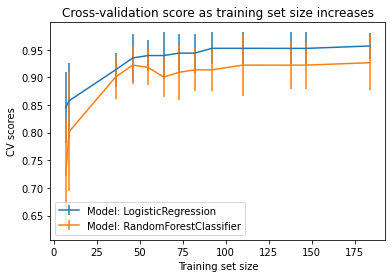

In [64]:
lab = [log_pipe, 'DT_pipe',RF_pipe]
fractions = [.04, .05, .2, .25, .3, .35, .4, .45, .5, .6, .75, .8, 1.0]
for i in range(0,len(lab),2):
    train_size, train_scores, test_scores = learning_curve(lab[i], X_train, y_train, train_sizes=fractions)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.plot(figsize=(10,5))
    plt.errorbar(train_size, test_scores_mean, yerr=test_scores_std, label="Model: " + str(model[i]).split('(')[0])
    plt.legend()
    plt.xlabel('Training set size')
    plt.ylabel('CV scores')
    plt.title('Cross-validation score as training set size increases');

In [65]:
# Save the model
# version of `sklearn`
# Date and time model created
#version of pandas
#version of numpy
#version of the developed model
#Let's call this model version '1.0'
best_model = log_grid_cv.best_estimator_
best_model.version = '1.0'
best_model.pandas_version = pd.__version__
best_model.numpy_version = np.__version__
best_model.sklearn_version = sklearn_version
#best_model.X_columns = [col for col in X_train.columns]
best_model.build_datetime = datetime.datetime.now()

In [ ]:
# save the model
from library.sb_utils import save_file

modelpath = '../models'
save_file(best_model, 'raman_covid_diagnostic.pkl', modelpath)

A file already exists with this name.

